# EDA before Adding Numerical Features

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

PALETTE = "PuRd"

In [38]:
dataset = pd.read_csv("../../../data/upftfg26/apujols/processed/dataset_temp.csv", sep=";")
dataset.head(3)

,filename,year,month,day,hour,minute,lng,lat,alt,camera,...,height,frames,fps,time,mean_brightness,class,date_str,datetime,bmin,bmax
0,M20251004_190700_MasLaRoca_NE,2025,10,4,19,7,2.19,41.56,570.0,NE,...,247.0,62.0,25.0,0.04,70.666667,unknown,M20251004,2025-10-04 19:07:00,54.0,79.0
1,M20251004_225201_MasLaRoca_NE,2025,10,4,22,52,2.19,41.56,570.0,NE,...,132.0,120.0,25.0,2.40,53.413793,unknown,M20251004,2025-10-04 22:52:00,44.0,63.0
2,M20251005_053814_MasLaRoca_NE,2025,10,5,5,38,2.19,41.56,570.0,NE,...,140.0,62.0,25.0,0.08,40.458333,unknown,M20251005,2025-10-05 05:38:00,39.0,46.0


First, lets select only the features we will need:

In [39]:
features_df = dataset[["filename", "time", "width", "height", "mean_brightness", "bmin", "bmax", "class"]]

features_df.head(3)

,filename,time,width,height,mean_brightness,bmin,bmax,class
0,M20251004_190700_MasLaRoca_NE,0.04,150.0,247.0,70.666667,54.0,79.0,unknown
1,M20251004_225201_MasLaRoca_NE,2.40,418.0,132.0,53.413793,44.0,63.0,unknown
2,M20251005_053814_MasLaRoca_NE,0.08,720.0,140.0,40.458333,39.0,46.0,unknown


In [40]:
features_df.describe()

,time,width,height,mean_brightness,bmin,bmax
count,29884.000000,29884.000000,29884.000000,29884.000000,29884.000000,29884.000000
mean,0.714713,203.680899,181.898708,74.024350,51.430130,94.577132
std,3.026511,145.971414,108.086451,34.958498,22.793659,50.088928
min,0.040000,66.000000,66.000000,11.000000,10.000000,11.000000
25%,0.040000,130.000000,129.000000,49.000000,39.000000,56.000000
50%,0.160000,142.000000,143.000000,63.333333,45.000000,78.000000
75%,0.440000,192.000000,183.000000,89.000000,57.000000,121.000000
max,113.680000,720.000000,576.000000,255.000000,255.000000,255.000000


In [41]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29884 entries, 0 to 29883
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   filename         29884 non-null  object 
 1   time             29884 non-null  float64
 2   width            29884 non-null  float64
 3   height           29884 non-null  float64
 4   mean_brightness  29884 non-null  float64
 5   bmin             29884 non-null  float64
 6   bmax             29884 non-null  float64
 7   class            29884 non-null  object 
dtypes: float64(6), object(2)
memory usage: 1.8+ MB


Now, we will take a look at the distribution of each variable:

<Axes: xlabel='class', ylabel='proportion'>

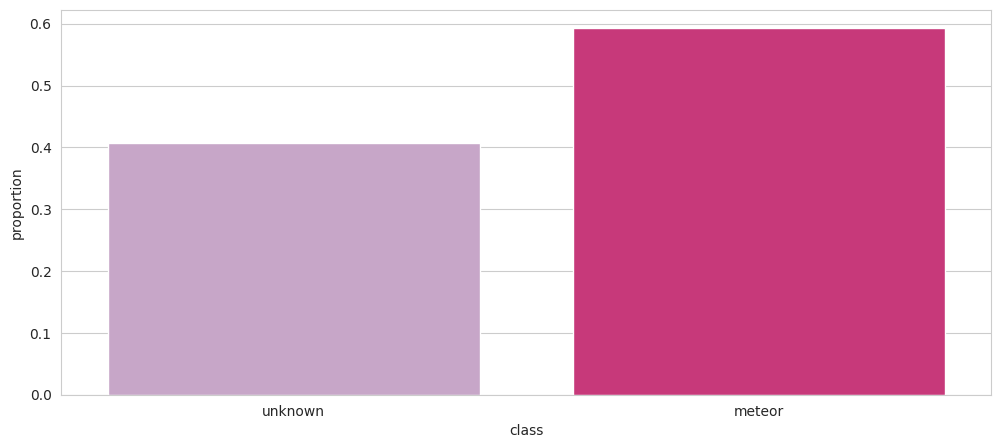

In [42]:
figure, ax = plt.subplots(1, 1, figsize=(12, 5))
sns.countplot(data=features_df, x="class", hue="class", palette=PALETTE, stat='proportion', ax=ax)

Look at each variable against the class:

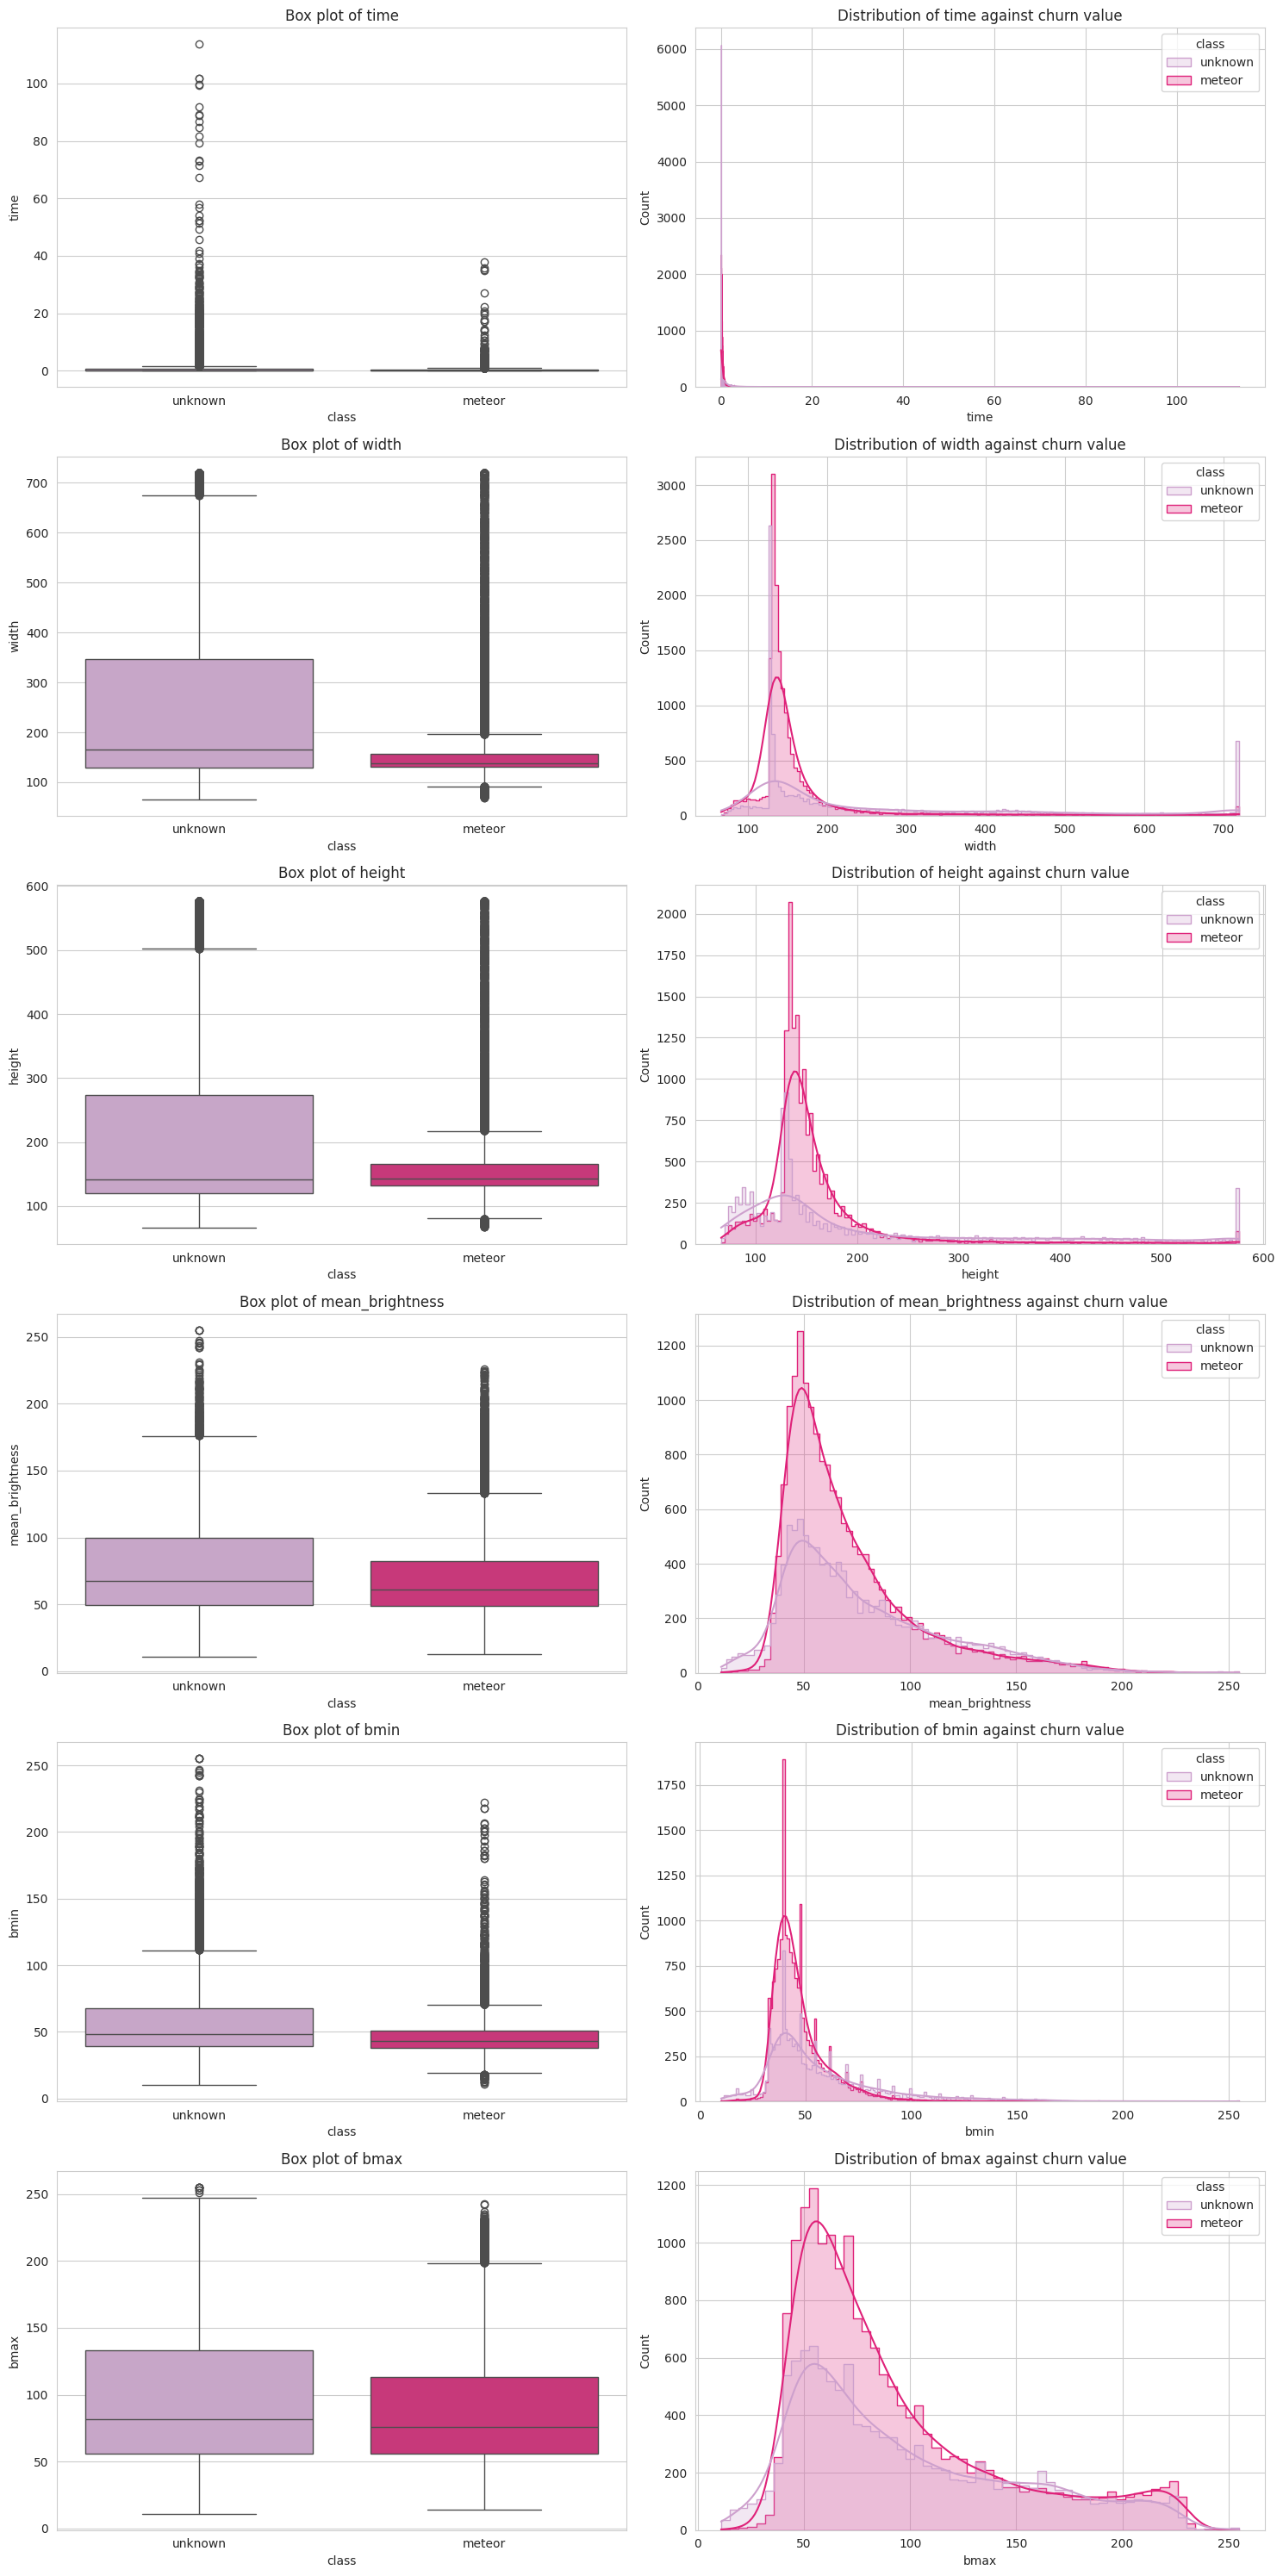

In [43]:
features_df_temp = features_df.copy(deep=True)
numerical_variables = ["time", "width", "height", "mean_brightness", "bmin", "bmax"]

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Determine the number of rows and columns for the subplot grid
num_vars = len(numerical_variables)
cols = 2  # Two plots for each variable: boxplot and distribution plot
rows = num_vars  # One row for each variable

# Create a figure
fig, axs = plt.subplots(rows, cols, figsize=(15, 5*rows))

# Box plots and distribution plots for numerical variables
for i, column in enumerate(numerical_variables):
    sns.boxplot(x='class', y=column, data=features_df_temp, hue='class', palette=PALETTE, ax=axs[i, 0])
    axs[i, 0].set_title(f'Box plot of {column}')

    sns.histplot(data=features_df_temp, x=column, hue='class', palette=PALETTE, kde=True, element='step', ax=axs[i, 1])
    axs[i, 1].set_title(f'Distribution of {column} against churn value')

# Adjust layout
plt.tight_layout()
plt.show()

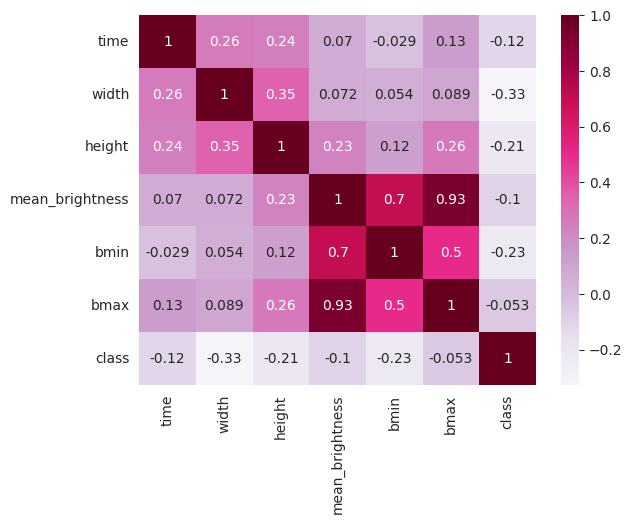

<Figure size 500x500 with 0 Axes>

In [44]:
features_df_temp['class'] = features_df_temp['class'].map({'meteor': 1, 'unknown': 0}).astype(float)

# Construct the correlation matrix with only numerical variables
sns.heatmap(features_df_temp[numerical_variables + ['class']].corr(), cmap=sns.color_palette(PALETTE, as_cmap=True), annot=True)
plt.figure(figsize=(5,5))
plt.show()

## Convert Target Variable

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, RobustScaler

# To make the numerical features smooth, reduce skew and heavy tails, make them robust to outliers, and put them on comparable scale
num_preprocess = Pipeline([
    # To make each distribution more Gaussian-like
    #  - reduces skew, stabilizes variance, makes features more symmetric and easier for linear layers to learn from
    ("power", PowerTransformer(method="yeo-johnson")),

    # Scales each feature using median and interquartile range (instead of mean and std)
    #   - resistant to outliers (many in meteor data), so it prevents them from dominating scale  
    ("scale", RobustScaler())
])

X_num = features_df[numerical_variables]
X_num_norm = num_preprocess.fit_transform(X_num)
X_norm = pd.DataFrame(X_num_norm, columns=numerical_variables)
X_norm.head(3)

,time,width,height,mean_brightness,bmin,bmax
0,-0.431208,0.153244,1.334150,0.183092,0.472650,0.016625
1,1.254283,1.744174,-0.249771,-0.292122,-0.060414,-0.282344
2,-0.268401,2.056335,-0.064598,-0.788236,-0.393028,-0.710429


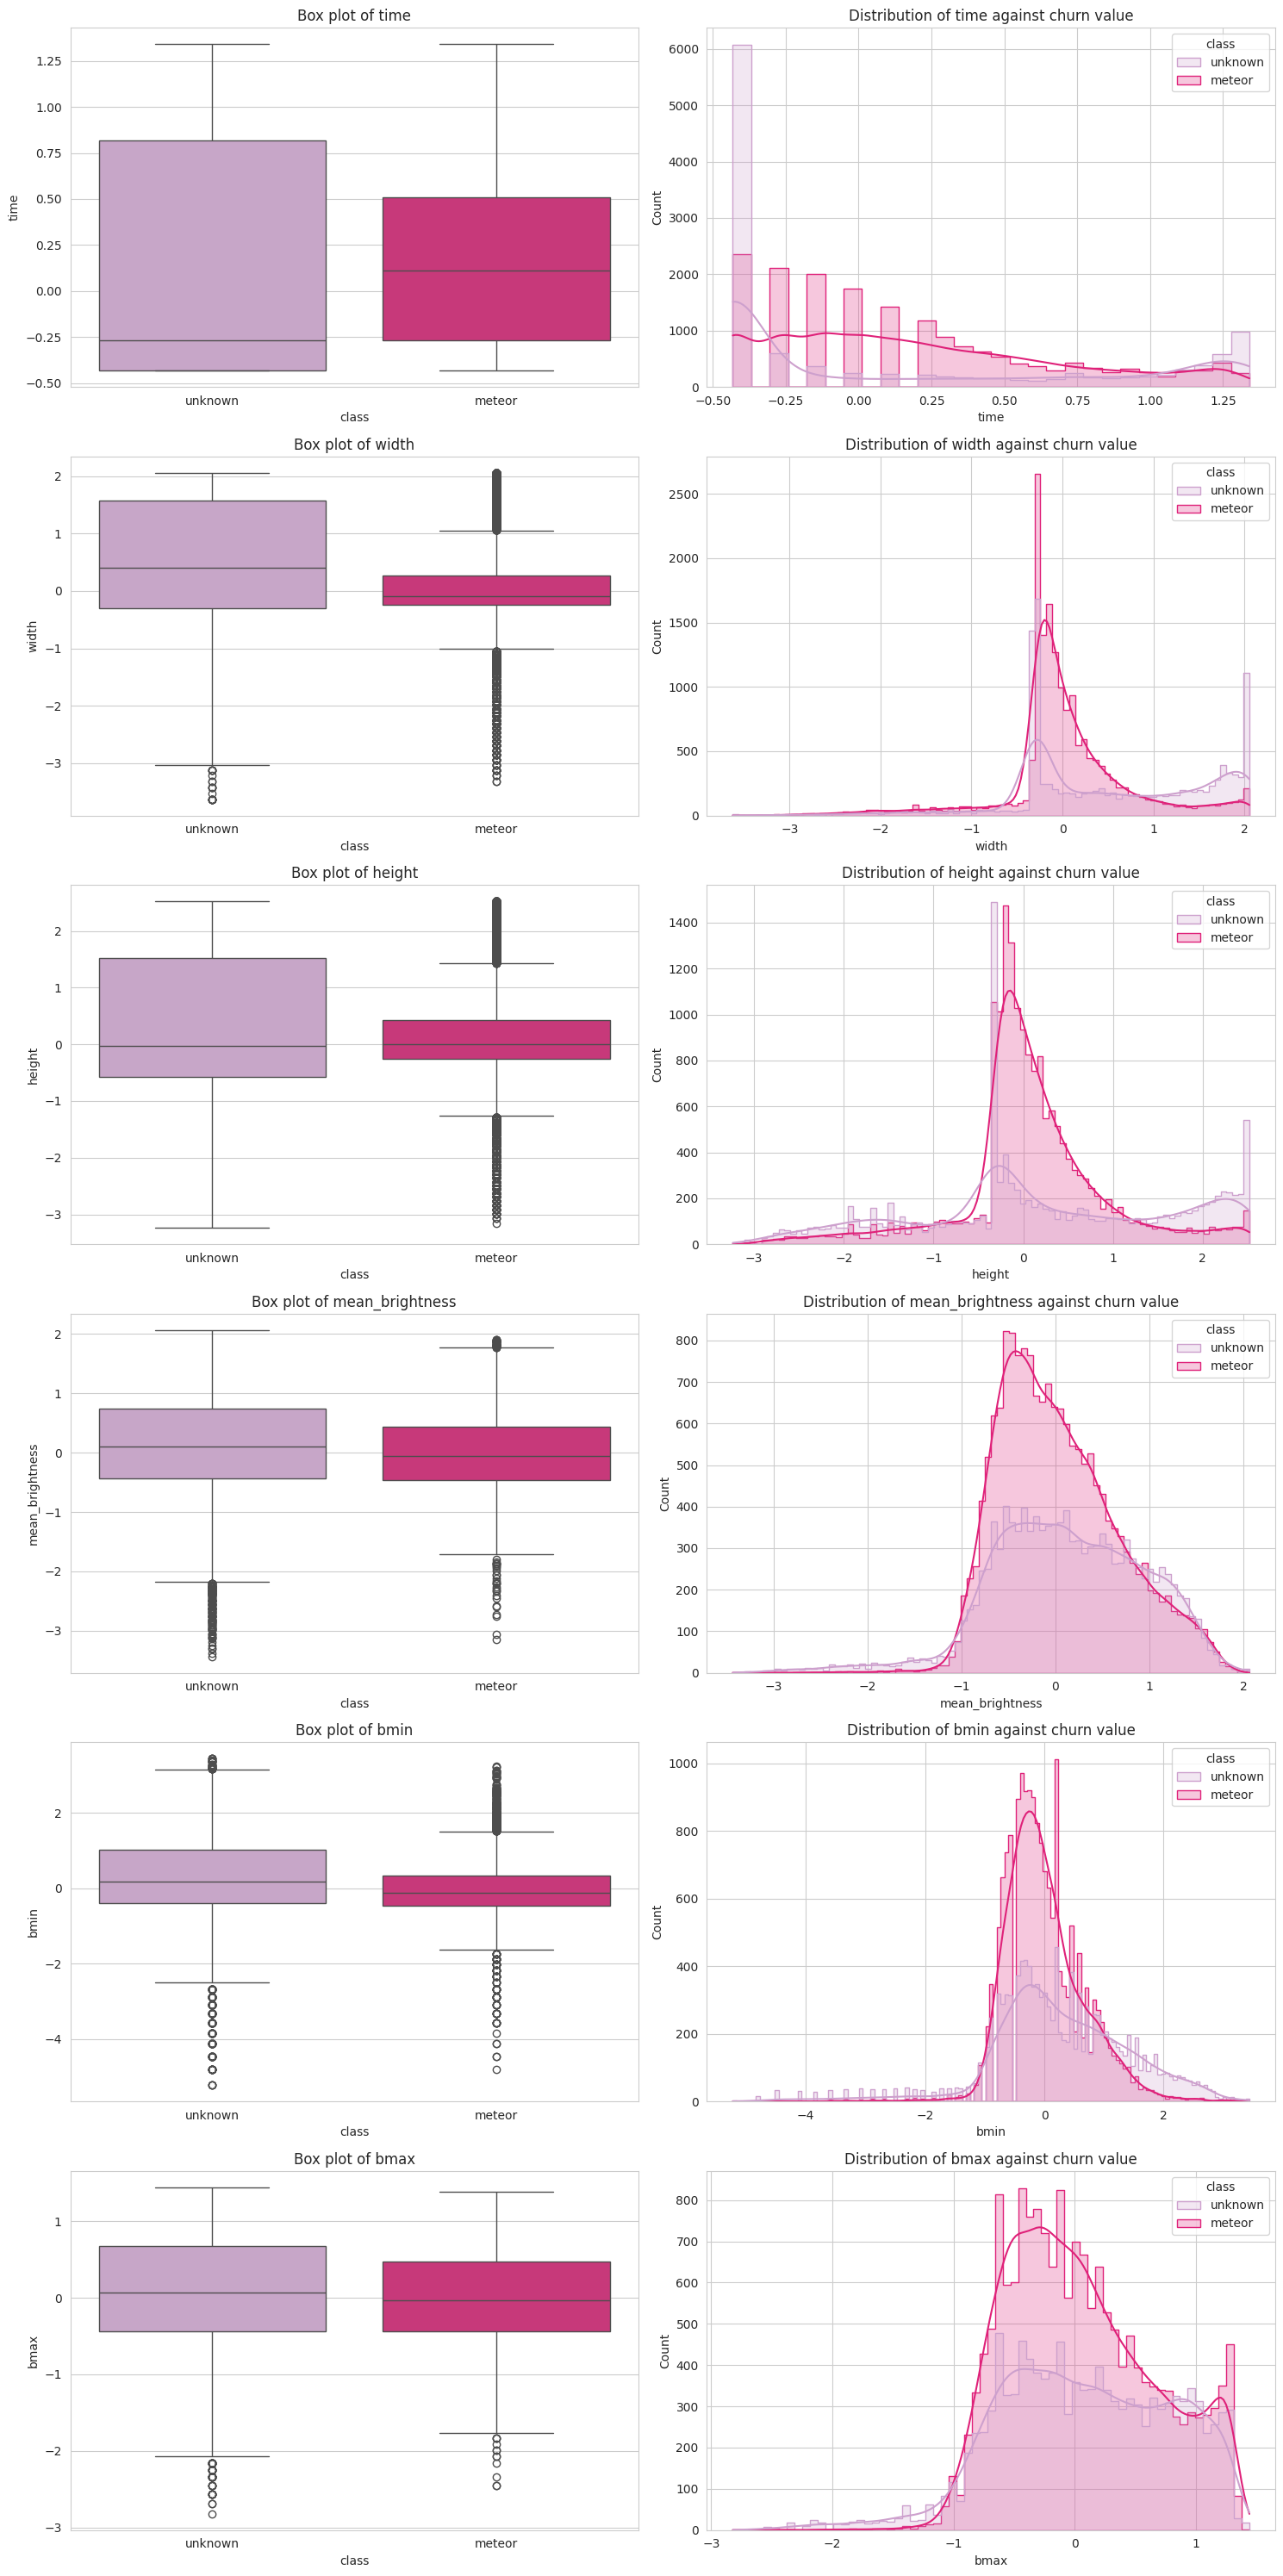

In [52]:
X_norm["class"] = features_df["class"].values

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Determine the number of rows and columns for the subplot grid
num_vars = len(numerical_variables)
cols = 2  # Two plots for each variable: boxplot and distribution plot
rows = num_vars  # One row for each variable

# Create a figure
fig, axs = plt.subplots(rows, cols, figsize=(15, 5*rows))

# Box plots and distribution plots for numerical variables
for i, column in enumerate(numerical_variables):
    sns.boxplot(x='class', y=column, data=X_norm, hue='class', palette=PALETTE, ax=axs[i, 0])
    axs[i, 0].set_title(f'Box plot of {column}')

    sns.histplot(data=X_norm, x=column, hue='class', palette=PALETTE, kde=True, element='step', ax=axs[i, 1])
    axs[i, 1].set_title(f'Distribution of {column} against churn value')

# Adjust layout
plt.tight_layout()
plt.show()